In [1]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import json
from antropy import lziv_complexity
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from itertools import combinations

c:\Users\pthoe\miniconda3\envs\gpt\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\pthoe\miniconda3\envs\gpt\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\pthoe\miniconda3\envs\gpt\lib\site-packages\umap\distances.py:1086: NumbaDeprecatio

# Dimensionality Reduction Plots

In [2]:
def plot_embedding(data, data_name, embedding_type="tSNE", colors=None, kde=False, legend=True, show=True):
    vecs_all = np.concatenate(list(data.values()))
    model_ids = np.concatenate([[i] * len(vecs) for i, vecs in enumerate(data.values())])

    if embedding_type.lower() == "tsne":
        emb = TSNE(n_components=2)
    elif embedding_type.lower() == "pca":
        emb = PCA(n_components=2)
    elif embedding_type.lower() == "umap":
        emb = UMAP(n_components=2)
    else:
        raise ValueError(f"Unknown embedding type {embedding_type}")

    emb_vecs = emb.fit_transform(vecs_all)

    plt.title(f"{embedding_type} embedding ({data_name})")
    for i, name in enumerate(data.keys()):
        cluster_data = emb_vecs[model_ids == i].T
        c = colors[i] if colors is not None else f"C{i}"
        plt.scatter(*cluster_data, label=name, alpha=0.8, s=40, c=c)

        if kde:
            sns.kdeplot(x=cluster_data[0], y=cluster_data[1], fill=True, color=c, alpha=0.1, thresh=0.01, levels=2)

    plt.axis("off")
    if legend:
        plt.legend()
    if show:
        plt.show()

In [3]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def euclidean_distance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)

def plot_pairwise_similarity(data, data_name, metric="cosine", pca_comps=None, cmap="Blues", show=True):
    if metric.lower() == "cosine":
        metric_fn = cosine_similarity
    elif metric.lower() == "euclidean":
        metric_fn = euclidean_distance
    else:
        raise ValueError(f"Unknown metric {metric}")

    if pca_comps is not None:
        vecs_all = np.concatenate(list(data.values()))
        pca = PCA(n_components=pca_comps)
        pca.fit(vecs_all)
        data = {k: pca.transform(v) for k, v in data.items()}

    sim_matrix = np.zeros((len(data), len(data)))
    for idx1, model1 in enumerate(data.keys()):
        for idx2, model2 in enumerate(data.keys()):
            if idx1 < idx2:
                continue
            vecs1, vecs2 = data[model1], data[model2]

            similarities = []
            for i in range(vecs1.shape[0]):
                for j in range(i + 1, vecs2.shape[0]):
                    v1, v2 = vecs1[i], vecs2[j]
                    similarities.append(metric_fn(v1, v2))
            sim_matrix[idx1, idx2] = np.mean(similarities)
    
    pca_suffix = f" of {pca_comps} PCs" if pca_comps is not None else ""
    if metric.lower() == "cosine":
        plt.title(f"Pairwise cosine similarity{pca_suffix} ({data_name})")
    elif metric.lower() == "euclidean":
        plt.title(f"Pairwise euclidean distance{pca_suffix} ({data_name})")

    mask = np.triu(np.ones_like(sim_matrix), k=1)
    sns.heatmap(sim_matrix, annot=True, xticklabels=list(data.keys()), yticklabels=list(data.keys()), mask=mask, cmap=cmap)
    if show:
        plt.show()

In [4]:
def load_data(data_locations, max_samples=100):
    data = {}
    for name, loc in data_locations.items():
        data[name] = np.array(list(json.load(open(loc, "r")).values()))[:max_samples]
    return data

def embedding_summary(data_locations, data_name, colors=None):
    data = load_data(data_locations)
    
    print(f"Number of samples per model ({data_name}):")
    for name, vecs in data.items():
        print("\t", name, vecs.shape[0])

    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plot_embedding(data, data_name, embedding_type="PCA", colors=colors, legend=False, show=False)
    plt.subplot(132)
    plot_embedding(data, data_name, embedding_type="tSNE", colors=colors, legend=False, show=False)
    plt.subplot(133)
    plot_embedding(data, data_name, embedding_type="UMAP", colors=colors, legend=False, show=False)
    plt.legend(loc="lower right", bbox_to_anchor=(0.2, 0))
    plt.show()

def pairwise_distance_summary(data_locations, data_name):
    data = load_data(data_locations)

    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plot_pairwise_similarity(data, data_name, metric="cosine", cmap="Blues", show=False)
    plt.subplot(122)
    plot_pairwise_similarity(data, data_name, metric="euclidean", pca_comps=2, cmap="Blues_r", show=False)
    plt.tight_layout()
    plt.show()

Number of samples per model (flash fiction):
	 GPT-3 (temp 1.0) 99
	 GPT-3 (temp 1.2) 98
	 GPT-4 (temp 0.8) 100
	 GPT-4 (temp 1.0) 93
	 GPT-4 (temp 1.2) 86


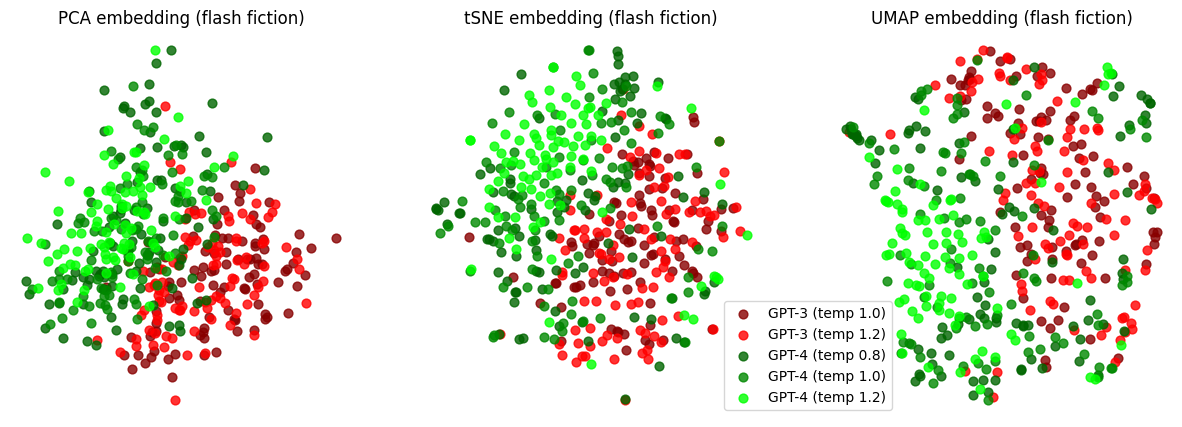

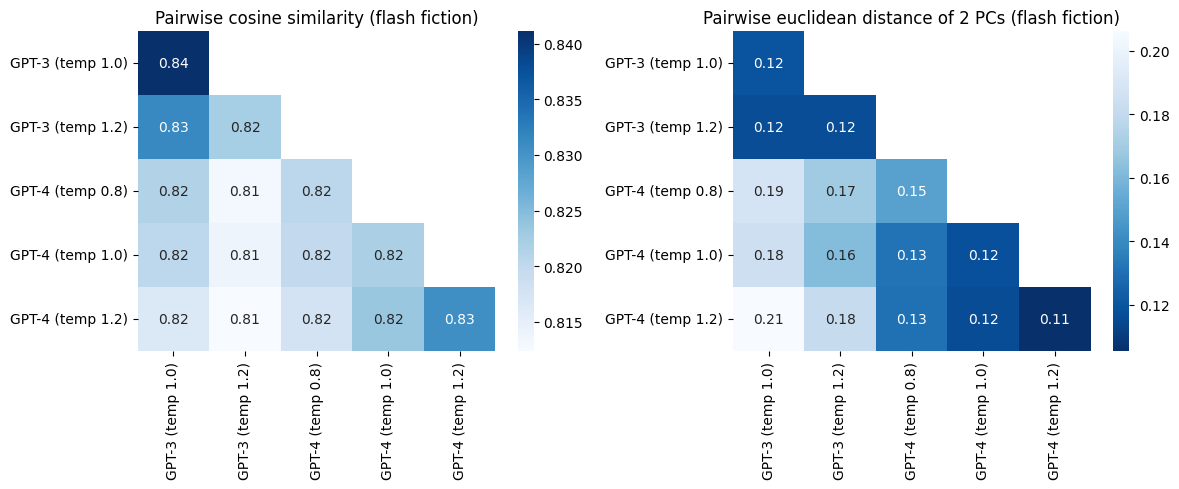

Number of samples per model (Haiku):
	 GPT-3 (temp 1.0) 93
	 GPT-3 (temp 1.5) 98
	 GPT-4 (temp 0.8) 100
	 GPT-4 (temp 1.0) 98
	 GPT-4 (temp 1.2) 100
	 GPT-4 (temp 1.4) 100
	 GPT-4 (temp 1.5) 100
	 Human 100


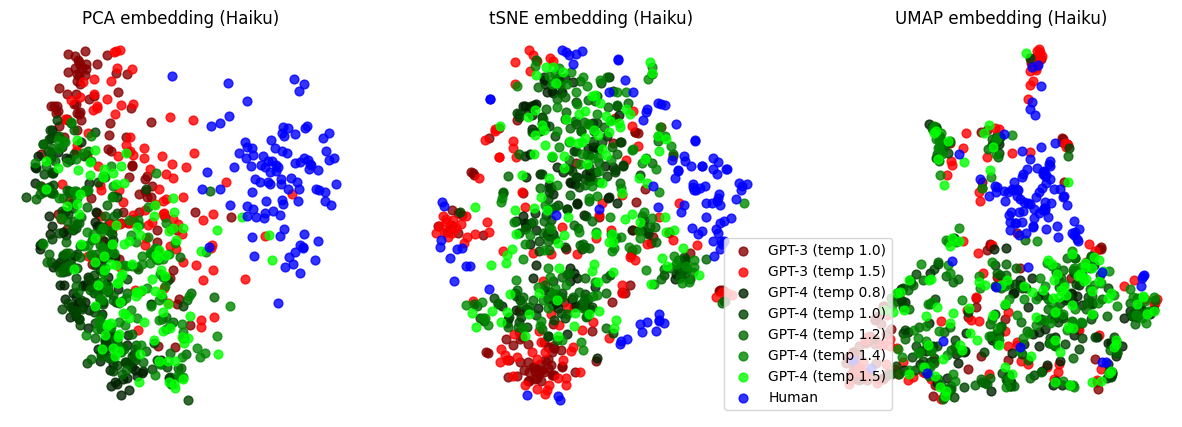

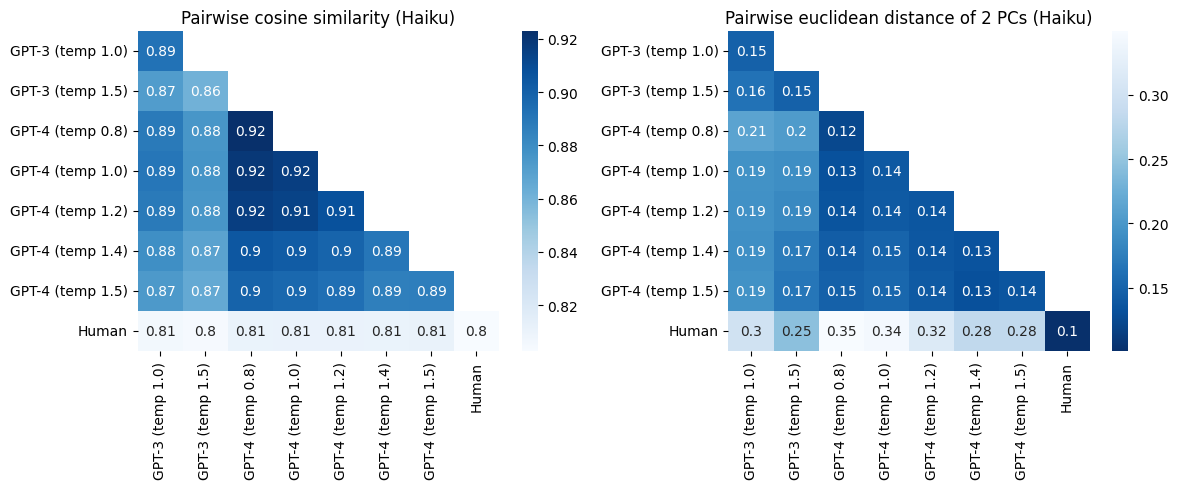

Number of samples per model (Synopsis):
	 GPT-3 (temp 1.0) 97
	 GPT-3 (temp 1.2) 98
	 GPT-4 (temp 1.0) 95
	 GPT-4 (temp 1.2) 100


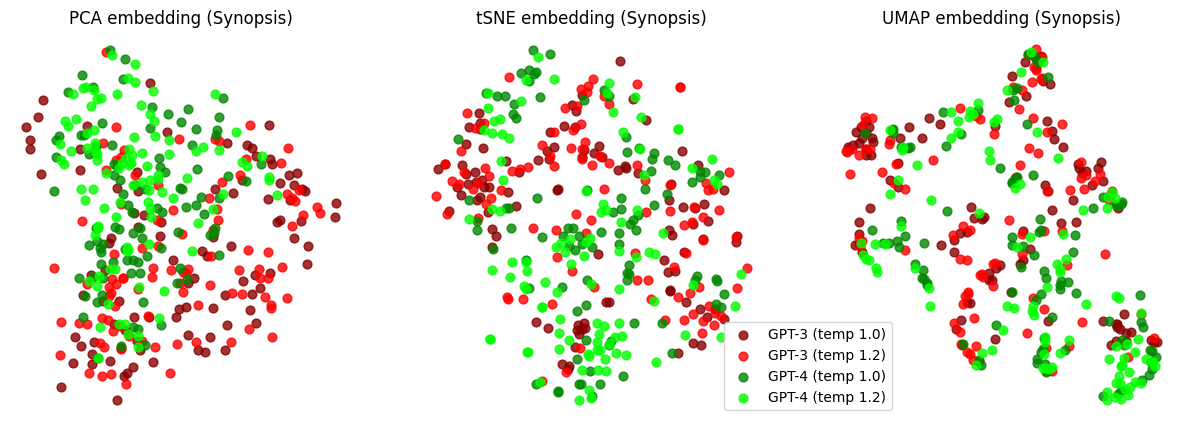

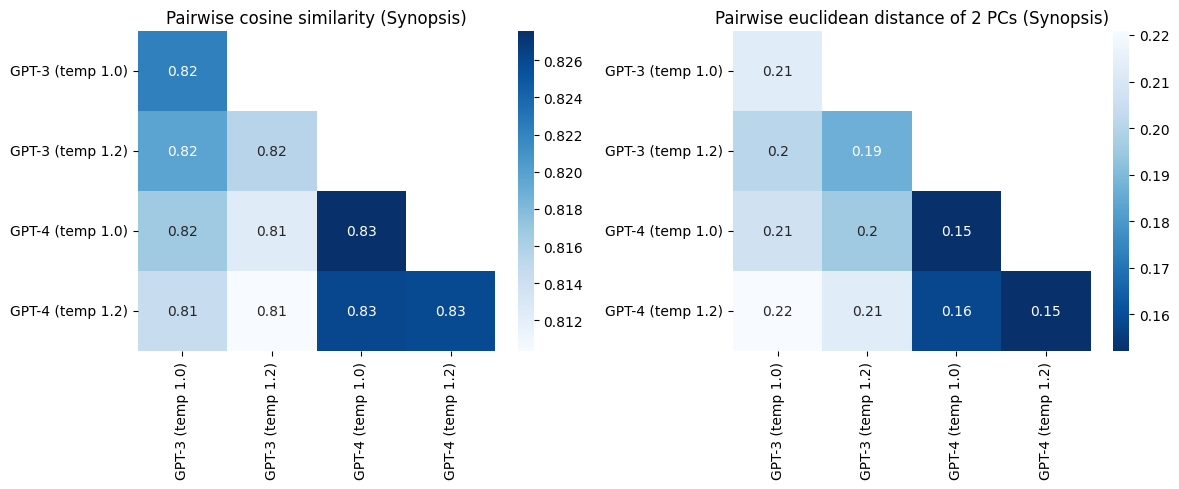

In [5]:
data_name = "flash fiction"
data_locations = {
    "GPT-3 (temp 1.0)": "../machine_data_stories/embeddings/GPT3_temp1.0_flash_fiction_nocrea100_vecs.json",
    "GPT-3 (temp 1.2)": "../machine_data_stories/embeddings/GPT3_temp1.2_flash_fiction_nocrea_vecs.json",
    "GPT-4 (temp 0.8)": "../machine_data_stories/embeddings/GPT4_temp0.8_flash_fiction_nocrea110_vecs.json",
    "GPT-4 (temp 1.0)": "../machine_data_stories/embeddings/GPT4_temp1.0_flash_fiction_nocrea100_vecs.json",
    "GPT-4 (temp 1.2)": "../machine_data_stories/embeddings/GPT4_temp1.2_flash_fiction_nocrea_vecs.json",
}
embedding_summary(data_locations, data_name, colors=["#880000", "#ff0000", "#006600", "#008800", "#00ff00"])
pairwise_distance_summary(data_locations, data_name)

data_name = "Haiku"
data_locations = {
    "GPT-3 (temp 1.0)": "../machine_data_stories/embeddings/GPT3_temp1.0_haiku_nocrea100_vecs.json",
    "GPT-3 (temp 1.5)": "../machine_data_stories/embeddings/GPT3_temp1.5_haiku_nocrea_vecs.json",
    "GPT-4 (temp 0.8)": "../machine_data_stories/embeddings/GPT4_temp0.8_haiku_nocrea110_vecs.json",
    "GPT-4 (temp 1.0)": "../machine_data_stories/embeddings/GPT4_temp1.0_haiku_nocrea100_vecs.json",
    "GPT-4 (temp 1.2)": "../machine_data_stories/embeddings/GPT4_temp1.2_haiku_nocrea130_vecs.json",
    "GPT-4 (temp 1.4)": "../machine_data_stories/embeddings/GPT4_temp1.4_haiku_nocrea110_vecs.json",
    "GPT-4 (temp 1.5)": "../machine_data_stories/embeddings/GPT4_temp1.5_haiku_nocrea_vecs.json",
    "Human": "../machine_data_stories/embeddings/human_haiku_tempslibres_vecs.json",
}
embedding_summary(data_locations, data_name, colors=["#880000", "#ff0000", "#002200", "#004400", "#006600", "#008800", "#00ff00", "#0000ff"])
pairwise_distance_summary(data_locations, data_name)

data_name = "Synopsis"
data_locations = {
    "GPT-3 (temp 1.0)": "../machine_data_stories/embeddings/GPT3_temp1.0_synopsis_nocrea100_vecs.json",
    "GPT-3 (temp 1.2)": "../machine_data_stories/embeddings/GPT3_temp1.2_synopsis_nocrea_vecs.json",
    "GPT-4 (temp 1.0)": "../machine_data_stories/embeddings/GPT4_temp1.0_synopsis_nocrea100_vecs.json",
    "GPT-4 (temp 1.2)": "../machine_data_stories/embeddings/GPT4_temp1.2_synopsis_nocrea_vecs.json",
}
embedding_summary(data_locations, data_name, colors=["#880000", "#ff0000", "#008800", "#00ff00"])
pairwise_distance_summary(data_locations, data_name)

# Lempel-Ziv complexity

In [6]:
def complexity_plot(fnames, data_name, alpha=0.01, show=True):
    texts = {name: list(json.load(open(f"../machine_data_stories/{fname}", "r")).values()) for name, fname in fnames.items()}

    complexities = []
    for name, text in texts.items():
        scores = [lziv_complexity(t, normalize=True) for t in text]
        complexities.append(scores)

    p_values = []
    for i in range(len(complexities)):
        for j in range(i+1, len(complexities)):
            t_stat, p_val = ttest_ind(complexities[i], complexities[j])
            p_values.append(p_val)
    
    reject, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh', alpha=alpha)

    plt.title(f"Lempel-Ziv complexity ({data_name})")
    sns.violinplot(data=complexities)
    plt.xticks(range(len(complexities)), list(fnames.keys()), rotation=45, ha="right")

    # Initialize maximum Y value for brackets
    y_max = 0

    # Draw brackets for significance
    for i, (x1, x2) in enumerate(combinations(range(len(complexities)), 2)):
        if reject[i]:
            # Define bracket height and offset
            y, h, col = max(max(complexities[x1]), max(complexities[x2])) + 0.02, 0.02, 'k'
            if y <= y_max:  # If the starting point of the bracket is lower than the previous max, shift it up
                y = y_max + 0.03
            y_max = y + h  # Update maximum Y value
            plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color=col)  # Draw the bracket
            plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)  # Mark with asterisk
    
    if show:
        plt.show()

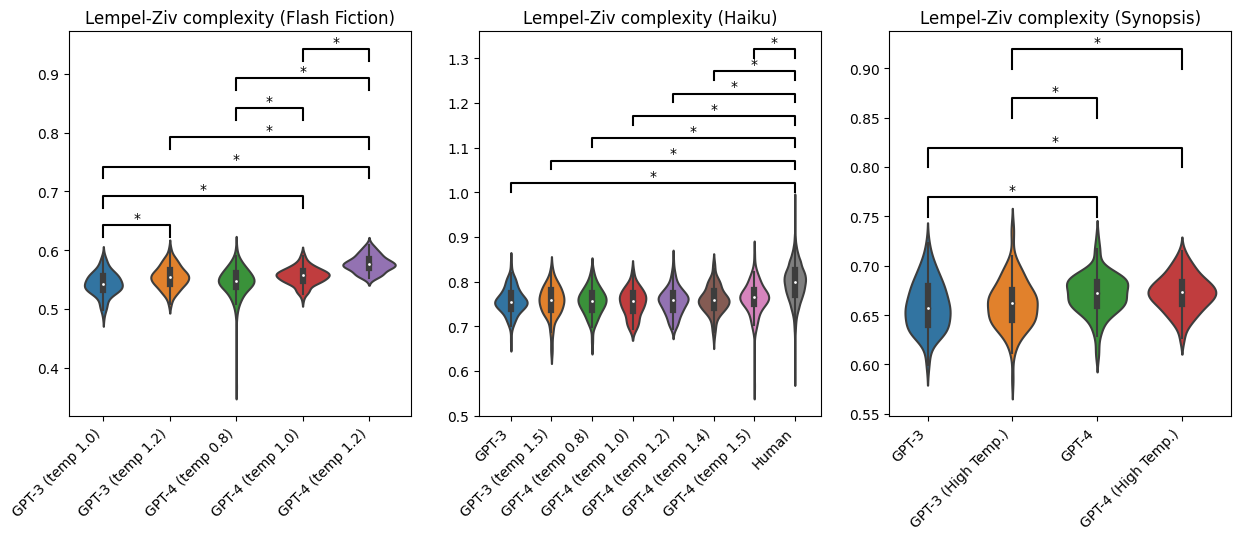

In [7]:
plt.figure(figsize=(15, 5))

# flash fiction
fnames = {
    "GPT-3 (temp 1.0)": "GPT3_temp1.0_flash_fiction_nocrea100.json",
    "GPT-3 (temp 1.2)": "GPT3_temp1.2_flash_fiction_nocrea.json",
    "GPT-4 (temp 0.8)": "GPT4_temp0.8_flash_fiction_nocrea110.json",
    "GPT-4 (temp 1.0)": "GPT4_temp1.0_flash_fiction_nocrea100.json",
    "GPT-4 (temp 1.2)": "GPT4_temp1.2_flash_fiction_nocrea.json",
}
plt.subplot(1, 3, 1)
complexity_plot(fnames, "Flash Fiction", show=False)

# haiku
fnames = {
    "GPT-3": "GPT3_temp1.0_haiku_nocrea100.json",
    "GPT-3 (temp 1.5)": "GPT3_temp1.5_haiku_nocrea.json",
    "GPT-4 (temp 0.8)": "GPT4_temp0.8_haiku_nocrea110.json",
    "GPT-4 (temp 1.0)": "GPT4_temp1.0_haiku_nocrea100.json",
    "GPT-4 (temp 1.2)": "GPT4_temp1.2_haiku_nocrea130.json",
    "GPT-4 (temp 1.4)": "GPT4_temp1.4_haiku_nocrea110.json",
    "GPT-4 (temp 1.5)": "GPT4_temp1.5_haiku_nocrea.json",
    "Human": "human_haiku_tempslibres.json",
}
plt.subplot(1, 3, 2)
complexity_plot(fnames, "Haiku", show=False)

# synopsis
fnames = {
    "GPT-3": "GPT3_temp1.0_synopsis_nocrea100.json",
    "GPT-3 (High Temp.)": "GPT3_temp1.2_synopsis_nocrea.json",
    "GPT-4": "GPT4_temp1.0_synopsis_nocrea100.json",
    "GPT-4 (High Temp.)": "GPT4_temp1.2_synopsis_nocrea.json",
}
plt.subplot(1, 3, 3)
complexity_plot(fnames, "Synopsis", show=False)
